# Medium claps predictor

## Idea

In [1]:
import os
# import torch 
# import torchtext
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import numpy as np
%matplotlib inline

In [2]:
# # За детерминизм!
# SEED = 0xDEAD
# random.seed(SEED)
# np.random.seed(SEED)
# torch.random.manual_seed(SEED)
# torch.cuda.random.manual_seed_all(SEED)

In [3]:
import pandas as pd

In [4]:
# torch.cuda.is_available()

True

## Data Preparation

In [331]:
DATA_PATH = './data/'
TRAIN_PATH = os.path.join(DATA_PATH, 'articles_train.csv')
TEST_PATH = os.path.join(DATA_PATH, 'articles_test.csv')

In [332]:
train_data = pd.read_csv(TRAIN_PATH, index_col='id')

In [465]:
train_data.sample(3)

,author,reading_time,link,title,text,claps
id,,,,,,
0,Joseph Rocca,23,https://towardsdatascience.com/understanding-v...,Understanding Variational Autoencoders (VAEs) ...,"Towards Data Science\nSep 24, 2019\nThis post ...",8300.0
1,Guido Vivaldi,6,https://towardsdatascience.com/using-mixed-eff...,Using Mixed-Effects Models For Linear Regressi...,"Towards Data Science\nMay 17, 2019\nMixed-effe...",336.0
2,Jerry Chen,11,https://news.greylock.com/the-new-moats-53f61a...,The New Moats. Why Systems of IntelligenceTM a...,"Greylock Perspectives\nApr 24, 2017\nTo build ...",3500.0


In [8]:
num_cols = ['reading_time', 'claps']
cat_cols = ['author', 'link', 'title', 'text']

In [9]:
train_data[num_cols].describe()

,reading_time,claps
count,3756.000000,3756.000000
mean,8.130192,1449.118477
std,6.259317,4736.590527
min,1.000000,0.000000
25%,5.000000,48.000000
50%,7.000000,231.000000
75%,10.000000,942.750000
max,149.000000,86000.000000


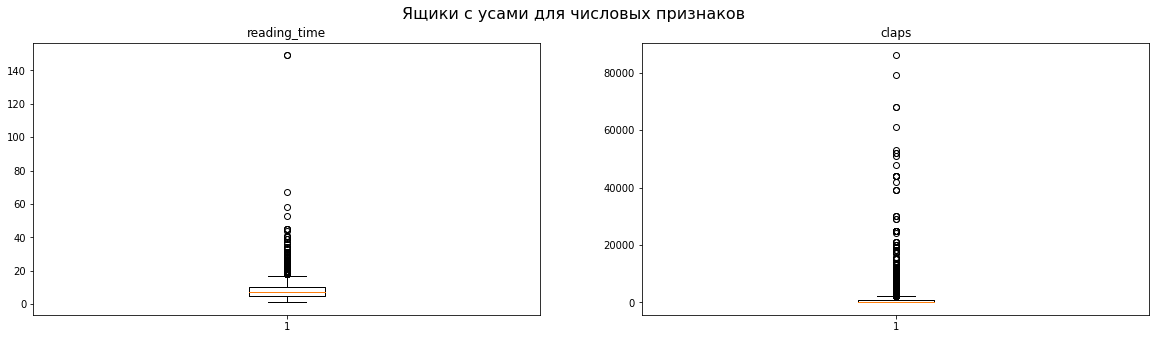

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=len(num_cols), figsize=(20,5))
fig.suptitle('Ящики с усами для числовых признаков', fontsize=16)
for i in range(len(num_cols)):
    ax[i].boxplot(train_data[num_cols[i]])
    ax[i].set_title(num_cols[i])
plt.show()

In [11]:
train_data.author.value_counts()

Jan Schultink        26
Susan Li             21
Renu Khandelwal      20
Synced               20
Charlie Kufs         18
                     ..
Merve Elif Saraç     1
Purit Punyawiwat      1
Dickson Wu            1
Malhar                1
Neha Tripathi         1
Name: author, Length: 2176, dtype: int64

## Feature Engineering

In [26]:

# ! title clastering (maybe topic modeling LDA)
# ! link parser (some sites are more popular than another)
# ? text parser (only text without titles/dates...)
# ! link scrapper (img per 1000 words, image sizes, count of words)
# ! catboost, lgbm, ridge, random_forest

In [3]:
import requests
import re
import time
import pandas as pd
import numpy as np
import datetime
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

def is_English(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

def clean_string(a_string):
    new_string = re.sub(r'‘|’|"|—|“|”|,', '', a_string).strip()
    new_string = re.sub(r'–', ' ', new_string)
    #new_string = re.sub(r'é', 'e', new_string)
    return new_string

def filter_string(a_string):
    if a_string == '.':
        return False
    elif a_string == '':
        return False
    else:
        return True

In [567]:
import re

class ArticleScraper():
    """
    Scrapes all data for an article.
    """
    def __init__(self):
        self.scraper_class = 'ArticleScraper' 

    
    def get_title(self, soup):
        try:
            title = soup.find('h1').text
            return title
        
        except:
            print("Couldn't get title from article.")

    
    def get_subtitle(self, soup):
        try:
            return soup.find('section').find('h2').text
        except:
            print("Couldn't get subtitle from article.")


    def get_publication(self, soup):
        try:
            for div in soup.find_all("div"):
                if div.text == 'Published in':
                    try:
                        return div.next_element.next_element.next_element.find('p').text
                    except:
                        continue
        except:
            print("Couldn't get publication type from article.")


    def get_author(self, soup):
        try:
            return soup.find('h2', class_=r"pw-author-name").text
        except:
            print("Couldn't get author from article.") 


    def get_reading_time(self, soup):
        try:
            return int(soup.find('div', class_=r"pw-reading-time").text.split()[0])
        except:
            print("Couldn't get reading time from article.")


    def get_date(self, soup):
        try:
            date_string = soup.find('p', class_=r"pw-published-date").text 
            return datetime.datetime.strptime(date_string, '%b %d, %Y').strftime('%d/%m/%Y')
        except:
            print("Couldn't get date from article.") 

    def get_followers(self, soup):
        # try:
        #     link = soup.find('div', class_=r"pw-author").find('a').get('href')
        #     if link[0] == '/':
        #         driver.get('https://medium.com' + link)
        #     else:
        #         driver.get(link)
        #     time.sleep(3)
        #     new_soup = BeautifulSoup(driver.page_source, 'lxml')
        # except:
        #     print("Can't go to user's account")
        # try:
        #     link = new_soup.find_all('a', {'role': 'tab'})[-1].get('href')
        #     if link[0] == '/':
        #         driver.get('https://medium.com' + link)
        #     else:
        #         driver.get(link)
        #     time.sleep(3)
        #     new_soup = BeautifulSoup(driver.page_source, 'lxml')
        #     # for button in soup.find_all('button'):
            #     if 'Followers' in button.text or 'followers' in button.text:
            #         fol_string = button.text.split()[0]
            # tens = {'K': 10e2, 'M': 10e5, 'B': 10e8, 'k': 10e2, 'm': 10e5, 'b': 10e8}
            # if (fol_string[-1] != 'K' and fol_string[-1] != 'M' 
            #             and fol_string[-1] != 'k' and fol_string[-1] != 'm'
            #             and fol_string[-1] != 'b' and fol_string[-1] != 'B'):
            #             return int(fol_string)
            # f = lambda x: int(float(x[:-1])*tens[x[-1]])
            # return f(fol_string)
        try:
            for button in soup.find_all('button'):
                if 'Followers' in button.text or 'followers' in button.text:
                    fol_string = button.text.split()[0]
            tens = {'K': 10e2, 'M': 10e5, 'B': 10e8, 'k': 10e2, 'm': 10e5, 'b': 10e8}
            if (fol_string[-1] != 'K' and fol_string[-1] != 'M' 
                        and fol_string[-1] != 'k' and fol_string[-1] != 'm'
                        and fol_string[-1] != 'b' and fol_string[-1] != 'B'):
                        return int(fol_string)
            f = lambda x: int(float(x[:-1])*tens[x[-1]])
            return f(fol_string)
        except:
            print("Can't go to the followers info")    

    
    def get_mean_size(self, soup):
        try:
            pics = soup.find('section').find_all('img')#, width=True, height=True)
            sums = (0,0)
            for pic in pics:
                url = pic.get('src')
                im = Image.open(requests.get(url, stream=True).raw)
                sums = tuple(map(sum, zip(sums, im.size)))
            mean = tuple(ti//len(pics) for ti in sums)
            if len(pics) == 0:
                return (0,0)
            return mean
        except:
            print("Can't get image's sizes")
         

    def count_figures(self, soup):
        try:
            return len(soup.find('section').find_all('img'))
        except:
            print("Can't get amount of pictures")

    def get_pure_text(self, soup):
        try:
            pure_text = ''
            for unparsed in soup.find('section').find_all('p'):
                pure_text += unparsed.text
            return pure_text
        except:
            print("Can't get pure text")
    
    
    def count_words(self, soup):
        try:
           pure_text = self.get_pure_text(soup=soup)
           return len(pure_text.split())
        except:
            print("Can't get words count from the article")

    
    def count_lists(self, soup):
        try:
            return len(soup.find('section').find_all('ol')) + len(soup.find('section').find_all('ul'))
        except:
            print("Can't get lists count")
    
    def bold_text_count(self, soup):
        try:
            return len(soup.find('section').find_all('strong'))
        except:
            print("Can't get bold text count")
    

    def get_blockquotes(self, soup):
        try:
            notes = []
            blockquotes = soup.find_all('blockquote')
            for blockquote in blockquotes:
                notes.append(blockquote.text)
            return notes
        except:
            print("Couldn't get notes from article.")


    def italic_text_count(self, soup):
        try:
            return len(soup.find('section').find_all('em'))
        except:
            print("Can't get italic text count")

    def count_vids(self, soup):
        try:
            yt_vids = []
            article_soup = soup.find('article')
            for figure in article_soup.find_all('figure'):
                yt_soup = figure.find('iframe', src=re.compile('.*youtube.*'))
                if yt_soup == None:
                    continue
                else:
                    yt_vids.append(yt_soup)
                    
            return len(yt_vids)
                    
        except:
            print("Couldn't get YouTube videos.") 
    

    def count_gists(self, soup):
        try:
            gists = []
            article_soup = soup.find('article')
            for fig in article_soup.find_all('figure'):
                gist_soup = fig.find('iframe', title=re.compile('.*\.py'))
                if gist_soup == None:
                    continue
                else:
                    gists.append(gist_soup)
            return len(gists)
        except:
            print("Couldn't get count of gists.") 


    def count_links(self, soup):
        try:
            links = []
            for a in soup.find('section').find_all('a'):
                link = a.get('href')
                if link != None:
                    links.append(link)
            return len(links)
        except:
            print("Couldn't get amount of links.") 

    def count_code_chunks(self, soup):
        try:
            return len(soup.find_all('pre'))
        except:
            print("Couldn't get amount of code chunks from article.")

    def scrape(self, soup):
        im_size = self.get_mean_size(soup)
        if im_size == None:
            im_size = (None, None)
        article_data = {
            "title": self.get_title(soup),
            "publication": self.get_publication(soup),
            #"subtitle": self.get_subtitle(soup),
            "author": self.get_author(soup),
            "followers": self.get_followers(soup),
            "reading_time": self.get_reading_time(soup),
            "n_words": self.count_words(soup),
            "pure_text": self.get_pure_text(soup),
            #"blockquotes": self.get_blockquotes(soup),
            "date": self.get_date(soup),
            "n_code_chunks": self.count_code_chunks(soup),
            "bold_text_count": self.bold_text_count(soup),
            "italic_text_count": self.italic_text_count(soup),
            "mean_image_width": im_size[0],
            "mean_image_height": im_size[1],
            "n_images": self.count_figures(soup),
            "n_lists": self.count_lists(soup),
            #"n_gists": self.count_gists(soup),
            "n_vids": self.count_vids(soup),
            "n_links": self.count_links(soup)
        }
        '''
        # !'bold_text_count',
        # !'count_code_chunks',
        # !'count_figures',
        # !'count_gists',
        # !'count_links',
        # !'count_lists',
        # !'count_vids',
        # !'count_words',
        # !'get_author',
        # !'get_blockquotes',
        # ! 'get_date',
        # !'get_followers',
        # !'get_mean_size',
        # !'get_publication',
        # !'get_pure_text',
        # !'get_reading_time',
        # !'get_subtitle',
        # !'get_title',
        # !'italic_text_count',
        '''
            
        return(article_data)

In [568]:
cols = ['title', 'publication', #'subtitle', 
                    'author', 'followers', 'reading_time',
                     'n_words', 'pure_text',
                      'date', 'n_code_chunks', 'bold_text_count',
                       'italic_text_count', 'mean_image_width', 
                       'mean_image_height','n_images', 'n_lists', #'n_gists',
                        'n_vids',  'n_links']

In [569]:
cols += list(['idx'])

In [570]:
page_urls = train_data.link.values

In [571]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
import cv2
from tqdm import tqdm, tqdm_notebook
import lxml
from PIL import Image
from langdetect import detect

In [572]:
from selenium.webdriver.edge.options import Options

options = Options()
options.add_argument("--headless")

In [587]:
def scrape_page(link, options):
    page_url = link

    driver = webdriver.Edge(options=options)
    try:
        driver.get(page_url)
    except:
        print('Time out')
        return {
            "title": None,
            "publication": None,
            #"subtitle": self.get_subtitle(soup),
            "author": None,
            "followers": None,
            "reading_time": None,
            "n_words": None,
            "pure_text": None,
            #"blockquotes": self.get_blockquotes(soup),
            "date": None,
            "n_code_chunks": None,
            "bold_text_count": None,
            "italic_text_count": None,
            "mean_image_width": None,
            "mean_image_height": None,
            "n_images": None,
            "n_lists": None,
            #"n_gists": self.count_gists(soup),
            "n_vids": None,
            "n_links": None
        }
    time.sleep(0.1)
    soup = BeautifulSoup(driver.page_source, 'lxml')
    article_scrapper = ArticleScraper()
    return article_scrapper.scrape(soup=soup)

In [574]:
df=pd.DataFrame(columns=cols).set_index('idx')

In [588]:
with tqdm(page_urls[:289], unit="page") as tepoch:
    for idx, page_url in enumerate(tepoch):
        # driver = webdriver.Edge()
        # driver.get(page_url)
        # time.sleep(0.5)
        # soup = BeautifulSoup(driver.page_source, 'lxml')
        # article_scrapper = ArticleScraper()
        df_ = scrape_page(page_url, options)
        df_['idx'] = idx
        df_ = pd.DataFrame([df_]).set_index('idx')
        df = pd.concat([df, df_])

In [590]:
import time

In [592]:
with tqdm(page_urls[290:], unit="page") as tepoch:
    for idx, page_url in enumerate(tepoch):

        # driver = webdriver.Edge()
        # driver.get(page_url)
        # time.sleep(0.5)
        # soup = BeautifulSoup(driver.page_source, 'lxml')
        # article_scrapper = ArticleScraper()
        df_ = scrape_page(page_url, options)
        df_['idx'] = idx+290
        df_ = pd.DataFrame([df_]).set_index('idx')
        df = pd.concat([df, df_])

  0%|          | 10/3466 [02:04<12:00:06, 12.50s/page]

Can't go to the followers info


  1%|          | 19/3466 [03:52<11:55:31, 12.45s/page]

Can't get image's sizes


  1%|          | 41/3466 [08:24<10:18:55, 10.84s/page]

Couldn't get title from article.


  1%|▏         | 51/3466 [10:18<11:01:54, 11.63s/page]

Can't get image's sizes


  2%|▏         | 64/3466 [13:09<14:31:23, 15.37s/page]

Couldn't get title from article.


  2%|▏         | 66/3466 [13:32<12:45:50, 13.51s/page]

Can't get image's sizes
Couldn't get title from article.


  2%|▏         | 83/3466 [16:31<9:26:46, 10.05s/page] 

Can't get image's sizes


  3%|▎         | 89/3466 [17:37<9:51:25, 10.51s/page] 

Can't get image's sizes


  4%|▎         | 123/3466 [24:18<15:37:43, 16.83s/page]

Can't get image's sizes


  4%|▍         | 139/3466 [27:58<15:24:17, 16.67s/page]

Can't get image's sizes


  4%|▍         | 143/3466 [29:06<16:56:56, 18.36s/page]

Can't get image's sizes


  5%|▌         | 176/3466 [35:23<10:21:04, 11.33s/page]

Can't get image's sizes


  5%|▌         | 186/3466 [37:13<10:47:07, 11.84s/page]

Can't get image's sizes
Couldn't get title from article.
Can't go to the followers info
Couldn't get reading time from article.
Couldn't get date from article.
Couldn't get YouTube videos.


  5%|▌         | 187/3466 [37:24<10:33:17, 11.59s/page]

Can't get image's sizes
Couldn't get title from article.
Can't go to the followers info
Couldn't get reading time from article.
Couldn't get date from article.
Couldn't get YouTube videos.


  5%|▌         | 188/3466 [37:39<11:13:55, 12.34s/page]

Can't get image's sizes
Couldn't get title from article.
Can't go to the followers info
Couldn't get reading time from article.
Couldn't get date from article.
Couldn't get YouTube videos.


  5%|▌         | 190/3466 [38:06<11:50:20, 13.01s/page]

Can't get image's sizes
Couldn't get title from article.
Can't go to the followers info
Couldn't get reading time from article.
Couldn't get date from article.
Couldn't get YouTube videos.


  6%|▌         | 192/3466 [38:28<10:36:49, 11.67s/page]

Can't get image's sizes
Couldn't get title from article.
Couldn't get title from article.
Can't go to the followers info
Couldn't get reading time from article.
Can't get pure text
Can't get words count from the article
Can't get pure text
Couldn't get date from article.
Can't get bold text count
Can't get italic text count
Can't get amount of pictures
Can't get lists count
Couldn't get YouTube videos.
Couldn't get amount of links.


  6%|▌         | 193/3466 [38:42<11:16:14, 12.40s/page]

Can't get image's sizes
Couldn't get title from article.
Couldn't get title from article.
Can't go to the followers info
Couldn't get reading time from article.
Can't get pure text
Can't get words count from the article
Can't get pure text
Couldn't get date from article.
Can't get bold text count
Can't get italic text count
Can't get amount of pictures
Can't get lists count
Couldn't get YouTube videos.
Couldn't get amount of links.


  6%|▌         | 194/3466 [38:58<12:11:30, 13.41s/page]

Can't get image's sizes
Couldn't get title from article.
Couldn't get reading time from article.
Can't get pure text
Can't get words count from the article
Can't get pure text
Couldn't get date from article.
Can't get bold text count
Can't get italic text count
Can't get amount of pictures
Can't get lists count
Couldn't get YouTube videos.
Couldn't get amount of links.


  6%|▌         | 216/3466 [43:27<11:08:26, 12.34s/page]

Can't get image's sizes


  6%|▋         | 218/3466 [43:49<10:28:41, 11.61s/page]

Can't get image's sizes


  7%|▋         | 244/3466 [49:49<11:16:37, 12.60s/page]

Can't get image's sizes


  7%|▋         | 255/3466 [52:28<12:08:53, 13.62s/page]

Couldn't get title from article.


  8%|▊         | 264/3466 [55:11<13:33:49, 15.25s/page]

Can't get image's sizes


  8%|▊         | 269/3466 [56:10<11:03:40, 12.46s/page]

Can't get image's sizes


  8%|▊         | 276/3466 [57:57<15:33:13, 17.55s/page]

Can't get image's sizes


  8%|▊         | 282/3466 [59:32<13:50:11, 15.64s/page]

Can't get image's sizes


  8%|▊         | 287/3466 [1:00:46<11:15:46, 12.75s/page]

Can't get image's sizes


  8%|▊         | 293/3466 [1:02:15<12:03:35, 13.68s/page]

Can't get image's sizes


  9%|▊         | 299/3466 [1:03:19<9:51:38, 11.21s/page] 

Can't get image's sizes


  9%|▊         | 300/3466 [1:03:27<8:50:34, 10.05s/page]

Can't get image's sizes


  9%|▉         | 307/3466 [1:04:50<11:06:53, 12.67s/page]

Can't get image's sizes


  9%|▉         | 311/3466 [1:05:32<9:41:06, 11.05s/page] 

Can't get image's sizes


  9%|▉         | 320/3466 [1:07:12<9:58:58, 11.42s/page] 

Can't go to the followers info


  9%|▉         | 321/3466 [1:07:22<9:36:01, 10.99s/page]

Can't get image's sizes


 10%|▉         | 330/3466 [1:09:09<10:23:53, 11.94s/page]

Can't get image's sizes


 10%|█         | 348/3466 [1:13:13<17:29:54, 20.20s/page]

Can't get image's sizes


 10%|█         | 353/3466 [1:15:16<19:28:46, 22.53s/page]

Can't get image's sizes


 11%|█         | 364/3466 [1:17:59<15:50:11, 18.38s/page]

Can't get image's sizes


 11%|█         | 370/3466 [1:18:58<9:04:54, 10.56s/page] 

Can't get image's sizes


 11%|█         | 376/3466 [1:20:34<11:39:28, 13.58s/page]

Can't go to the followers info


 11%|█         | 386/3466 [1:22:46<14:03:40, 16.44s/page]

Can't get image's sizes


 12%|█▏        | 400/3466 [1:25:57<14:43:03, 17.28s/page]

Can't get image's sizes


 12%|█▏        | 424/3466 [1:31:49<10:23:28, 12.30s/page]

Can't get image's sizes


 13%|█▎        | 439/3466 [1:34:59<9:30:45, 11.31s/page] 

Can't get image's sizes


 13%|█▎        | 458/3466 [1:39:04<11:20:53, 13.58s/page]

Can't get image's sizes


 13%|█▎        | 459/3466 [1:39:16<10:44:36, 12.86s/page]

Can't get image's sizes


 14%|█▍        | 481/3466 [1:45:02<17:17:04, 20.85s/page]

Can't get image's sizes


 14%|█▍        | 485/3466 [1:46:03<13:06:47, 15.84s/page]

Can't get image's sizes


 14%|█▍        | 489/3466 [1:46:55<11:43:59, 14.19s/page]

Can't go to the followers info


 14%|█▍        | 492/3466 [1:47:34<10:27:39, 12.66s/page]

Can't go to the followers info


 14%|█▍        | 494/3466 [1:48:14<13:59:47, 16.95s/page]

Can't get image's sizes


 15%|█▍        | 515/3466 [1:52:52<11:22:01, 13.87s/page]

Can't get image's sizes


 16%|█▌        | 538/3466 [1:58:00<9:15:44, 11.39s/page] 

Can't get image's sizes
Couldn't get title from article.
Couldn't get title from article.
Can't go to the followers info
Couldn't get reading time from article.
Couldn't get date from article.
Couldn't get YouTube videos.


 16%|█▌        | 541/3466 [1:58:25<7:56:26,  9.77s/page]

Can't get image's sizes


 16%|█▌        | 553/3466 [2:00:41<9:36:47, 11.88s/page] 

Can't get image's sizes


 16%|█▋        | 564/3466 [2:02:57<9:53:04, 12.26s/page] 

Can't get image's sizes


 17%|█▋        | 589/3466 [2:07:47<8:47:35, 11.00s/page] 

Can't get image's sizes


 17%|█▋        | 595/3466 [2:09:06<12:17:37, 15.42s/page]

Can't get image's sizes
Can't get image's sizes


 18%|█▊        | 615/3466 [2:12:42<8:48:09, 11.12s/page] 

Can't get image's sizes
Couldn't get title from article.
Couldn't get title from article.
Can't go to the followers info
Couldn't get reading time from article.
Couldn't get date from article.
Couldn't get YouTube videos.


 18%|█▊        | 627/3466 [2:14:52<8:18:27, 10.53s/page]

Can't get image's sizes


 18%|█▊        | 633/3466 [2:16:29<12:36:23, 16.02s/page]

Can't get image's sizes


 18%|█▊        | 636/3466 [2:17:17<13:27:57, 17.13s/page]

Can't get image's sizes


 19%|█▉        | 654/3466 [2:20:30<8:03:02, 10.31s/page] 

Can't get image's sizes


 19%|█▉        | 662/3466 [2:21:54<8:21:09, 10.72s/page]

Couldn't get title from article.


 19%|█▉        | 664/3466 [2:22:32<12:25:22, 15.96s/page]

Can't get image's sizes


 19%|█▉        | 668/3466 [2:23:36<13:21:16, 17.18s/page]

Can't get image's sizes


 20%|█▉        | 691/3466 [2:28:12<8:52:14, 11.51s/page] 

Can't get image's sizes


 20%|██        | 704/3466 [2:30:41<11:47:11, 15.36s/page]

Can't get image's sizes


 21%|██        | 719/3466 [2:34:01<10:47:50, 14.15s/page]

Couldn't get title from article.


 21%|██        | 725/3466 [2:35:11<11:00:09, 14.45s/page]

Can't get image's sizes


 21%|██        | 736/3466 [2:37:43<12:32:26, 16.54s/page]

Can't get image's sizes
Can't get image's sizes


 21%|██▏       | 737/3466 [2:38:37<21:09:45, 27.92s/page]

Can't get image's sizes


 21%|██▏       | 743/3466 [2:39:39<9:26:56, 12.49s/page] 

Can't get image's sizes


 22%|██▏       | 749/3466 [2:40:43<8:31:13, 11.29s/page]

Can't get image's sizes
Couldn't get title from article.


 22%|██▏       | 777/3466 [2:46:08<9:58:51, 13.36s/page] 

Can't get image's sizes


 22%|██▏       | 779/3466 [2:46:27<8:27:54, 11.34s/page]

Can't get image's sizes


 23%|██▎       | 796/3466 [2:50:13<12:08:18, 16.37s/page]

Can't get image's sizes


 23%|██▎       | 802/3466 [2:51:42<10:06:22, 13.66s/page]

Can't get image's sizes


 23%|██▎       | 805/3466 [2:52:14<8:57:41, 12.12s/page] 

Can't get image's sizes


 24%|██▍       | 833/3466 [2:57:19<5:53:03,  8.05s/page] 

Can't go to the followers info


 24%|██▍       | 838/3466 [2:58:11<7:18:06, 10.00s/page]

Can't get image's sizes


 24%|██▍       | 844/3466 [2:59:12<7:49:11, 10.74s/page]

Can't get image's sizes


 25%|██▍       | 850/3466 [3:00:31<11:28:23, 15.79s/page]

Can't get image's sizes


 25%|██▍       | 857/3466 [3:02:01<11:23:27, 15.72s/page]

Can't get image's sizes


 25%|██▍       | 858/3466 [3:02:13<10:43:08, 14.80s/page]

Can't get image's sizes


 25%|██▍       | 859/3466 [3:02:21<9:15:43, 12.79s/page] 

Can't get image's sizes


 25%|██▌       | 873/3466 [3:05:31<8:52:35, 12.32s/page] 

Can't get image's sizes
Couldn't get title from article.


 25%|██▌       | 877/3466 [3:06:26<11:15:09, 15.65s/page]

Can't get image's sizes


 25%|██▌       | 879/3466 [3:06:54<10:23:17, 14.46s/page]

Can't get image's sizes


 25%|██▌       | 882/3466 [3:07:25<8:27:59, 11.80s/page] 

Can't get image's sizes
Couldn't get title from article.


 26%|██▌       | 906/3466 [3:11:56<11:33:15, 16.25s/page]

Can't get image's sizes


 26%|██▋       | 912/3466 [3:13:01<8:06:57, 11.44s/page] 

Can't get image's sizes


 27%|██▋       | 921/3466 [3:14:50<10:47:55, 15.28s/page]

Can't get image's sizes


 28%|██▊       | 954/3466 [3:20:25<7:42:10, 11.04s/page] 

Can't get image's sizes


 28%|██▊       | 974/3466 [3:24:02<7:11:42, 10.39s/page]

Can't get image's sizes


 28%|██▊       | 979/3466 [3:25:30<14:12:12, 20.56s/page]

Can't get image's sizes


 28%|██▊       | 987/3466 [3:26:55<7:54:23, 11.48s/page] 

Can't get image's sizes
Couldn't get title from article.


 29%|██▊       | 990/3466 [3:27:23<6:55:47, 10.08s/page]

Can't get image's sizes


 29%|██▉       | 998/3466 [3:29:09<11:37:15, 16.95s/page]

Can't get image's sizes


 29%|██▉       | 1006/3466 [3:30:43<7:55:13, 11.59s/page] 

Can't get image's sizes


 29%|██▉       | 1014/3466 [3:32:03<6:23:46,  9.39s/page]

Can't get image's sizes
Couldn't get title from article.


 29%|██▉       | 1015/3466 [3:32:10<5:57:39,  8.76s/page]

Can't get image's sizes


 29%|██▉       | 1018/3466 [3:32:47<7:33:35, 11.12s/page]

Can't get image's sizes


 29%|██▉       | 1020/3466 [3:33:03<6:36:56,  9.74s/page]

Can't get image's sizes


 30%|██▉       | 1035/3466 [3:35:45<7:43:14, 11.43s/page]

Can't get image's sizes


 30%|██▉       | 1039/3466 [3:36:39<10:20:44, 15.35s/page]

Can't get image's sizes


 30%|███       | 1045/3466 [3:37:49<8:10:23, 12.15s/page] 

Can't get image's sizes


 30%|███       | 1051/3466 [3:38:48<7:25:01, 11.06s/page]

Can't get image's sizes


 31%|███       | 1061/3466 [3:40:45<8:04:41, 12.09s/page]

Can't get image's sizes


 31%|███       | 1069/3466 [3:42:36<8:59:01, 13.49s/page] 

Can't get image's sizes


 31%|███       | 1071/3466 [3:42:55<7:45:37, 11.67s/page]

Can't get image's sizes


 31%|███       | 1083/3466 [3:44:59<7:15:16, 10.96s/page]

Can't get image's sizes


 32%|███▏      | 1098/3466 [3:47:54<10:22:43, 15.78s/page]

Can't get image's sizes


 32%|███▏      | 1101/3466 [3:48:27<8:08:02, 12.38s/page] 

Can't get image's sizes


 32%|███▏      | 1110/3466 [3:50:28<8:44:50, 13.37s/page] 

Can't get image's sizes


 32%|███▏      | 1121/3466 [3:52:46<8:23:58, 12.90s/page] 

Can't get image's sizes


 32%|███▏      | 1124/3466 [3:53:48<13:31:30, 20.79s/page]

Can't get image's sizes


 33%|███▎      | 1141/3466 [3:56:51<6:22:28,  9.87s/page] 

Can't get image's sizes
Couldn't get title from article.


 34%|███▍      | 1171/3466 [4:02:53<11:03:12, 17.34s/page]

Can't get image's sizes


 34%|███▍      | 1192/3466 [4:06:49<7:05:07, 11.22s/page] 

Can't get image's sizes


 34%|███▍      | 1194/3466 [4:07:05<6:09:36,  9.76s/page]

Can't get image's sizes


 35%|███▌      | 1218/3466 [4:11:37<6:29:32, 10.40s/page]

Can't get image's sizes
Couldn't get title from article.


 35%|███▌      | 1224/3466 [4:12:58<8:14:40, 13.24s/page] 

Can't go to the followers info


 36%|███▌      | 1233/3466 [4:14:44<6:57:52, 11.23s/page]

Can't get image's sizes


 36%|███▋      | 1263/3466 [4:20:56<9:41:17, 15.83s/page]

Couldn't get title from article.


 37%|███▋      | 1284/3466 [4:25:20<10:02:36, 16.57s/page]

Can't get image's sizes


 37%|███▋      | 1295/3466 [4:27:33<7:29:36, 12.43s/page] 

Can't get image's sizes
Can't go to the followers info


 38%|███▊      | 1320/3466 [4:32:23<8:11:03, 13.73s/page]

Couldn't get title from article.


 38%|███▊      | 1325/3466 [4:33:14<6:32:13, 10.99s/page]

Can't get image's sizes


 39%|███▉      | 1350/3466 [4:37:30<6:36:08, 11.23s/page]

Can't get image's sizes


 39%|███▉      | 1357/3466 [4:38:56<7:11:47, 12.28s/page]

Can't get image's sizes


 40%|███▉      | 1372/3466 [4:41:42<6:53:07, 11.84s/page]

Can't get image's sizes


 40%|███▉      | 1381/3466 [4:43:34<6:09:56, 10.65s/page]

Can't go to the followers info


 40%|████      | 1401/3466 [4:48:04<10:57:27, 19.10s/page]

Can't get image's sizes


 41%|████      | 1406/3466 [4:49:03<7:09:54, 12.52s/page] 

Can't get image's sizes


 41%|████      | 1409/3466 [4:49:39<7:14:11, 12.66s/page]

Can't get image's sizes


 41%|████      | 1418/3466 [4:51:18<5:56:37, 10.45s/page]

Can't get image's sizes


 41%|████      | 1421/3466 [4:51:49<6:05:19, 10.72s/page]

Can't get image's sizes


 41%|████      | 1423/3466 [4:52:23<8:25:03, 14.83s/page]

Can't get image's sizes


 41%|████▏     | 1436/3466 [4:54:45<5:21:34,  9.50s/page]

Can't go to the followers info


 42%|████▏     | 1457/3466 [4:58:22<6:18:36, 11.31s/page]

Can't get image's sizes


 42%|████▏     | 1458/3466 [4:58:29<5:37:48, 10.09s/page]

Can't get image's sizes


 42%|████▏     | 1470/3466 [5:00:36<8:05:36, 14.60s/page]

Can't get image's sizes


 42%|████▏     | 1472/3466 [5:00:58<6:58:27, 12.59s/page]

Couldn't get title from article.


 43%|████▎     | 1477/3466 [5:02:29<10:32:55, 19.09s/page]

Can't get image's sizes


 43%|████▎     | 1478/3466 [5:03:00<12:32:48, 22.72s/page]

Can't get image's sizes


 43%|████▎     | 1491/3466 [5:05:43<9:00:42, 16.43s/page] 

Can't get image's sizes


 43%|████▎     | 1492/3466 [5:05:57<8:34:52, 15.65s/page]

Can't get image's sizes


 43%|████▎     | 1497/3466 [5:07:14<7:28:39, 13.67s/page] 

Can't get image's sizes


 43%|████▎     | 1505/3466 [5:08:49<6:23:48, 11.74s/page]

Can't go to the followers info


 44%|████▎     | 1511/3466 [5:09:59<7:49:41, 14.42s/page]

Can't get image's sizes
Can't get image's sizes


 44%|████▍     | 1520/3466 [5:12:00<9:15:57, 17.14s/page]

Can't get image's sizes


 44%|████▍     | 1523/3466 [5:12:29<6:21:17, 11.77s/page]

Can't get image's sizes


 44%|████▍     | 1540/3466 [5:15:28<5:39:25, 10.57s/page]

Can't get image's sizes


 45%|████▍     | 1548/3466 [5:17:01<6:05:58, 11.45s/page]

Can't get image's sizes


 45%|████▍     | 1554/3466 [5:18:20<8:16:17, 15.57s/page]

Can't get image's sizes


 45%|████▌     | 1574/3466 [5:22:17<7:19:54, 13.95s/page]

Can't get image's sizes


 45%|████▌     | 1576/3466 [5:22:37<6:20:12, 12.07s/page]

Can't get image's sizes


 46%|████▌     | 1596/3466 [5:26:24<6:03:47, 11.67s/page]

Can't get image's sizes


 46%|████▋     | 1610/3466 [5:29:06<8:11:29, 15.89s/page]

Can't get image's sizes


 47%|████▋     | 1612/3466 [5:29:31<7:13:23, 14.03s/page]

Can't go to the followers info


 47%|████▋     | 1617/3466 [5:30:35<6:44:33, 13.13s/page]

Can't get image's sizes


 47%|████▋     | 1619/3466 [5:30:51<5:20:34, 10.41s/page]

Can't get image's sizes


 47%|████▋     | 1622/3466 [5:31:51<7:38:56, 14.93s/page]

Can't get image's sizes


 47%|████▋     | 1628/3466 [5:32:58<6:04:25, 11.90s/page]

Can't get image's sizes


 47%|████▋     | 1635/3466 [5:34:14<5:40:52, 11.17s/page]

Can't get image's sizes


 48%|████▊     | 1653/3466 [5:38:30<8:33:01, 16.98s/page]

Can't get image's sizes


 48%|████▊     | 1656/3466 [5:39:07<6:45:27, 13.44s/page]

Can't get image's sizes


 48%|████▊     | 1659/3466 [5:39:51<7:54:20, 15.75s/page]

Can't get image's sizes


 48%|████▊     | 1662/3466 [5:40:51<9:50:41, 19.65s/page]

Can't get image's sizes
Can't get image's sizes


 48%|████▊     | 1673/3466 [5:42:39<4:38:24,  9.32s/page]

Can't get image's sizes


 48%|████▊     | 1674/3466 [5:42:47<4:28:23,  8.99s/page]

Time out


 48%|████▊     | 1678/3466 [5:44:09<7:16:01, 14.63s/page] 

Can't go to the followers info


 49%|████▊     | 1683/3466 [5:45:04<5:52:12, 11.85s/page]

Couldn't get title from article.


 49%|████▊     | 1686/3466 [5:45:39<6:01:15, 12.18s/page]

Couldn't get title from article.


 49%|████▉     | 1697/3466 [5:48:21<8:46:30, 17.86s/page]

Can't get image's sizes


 49%|████▉     | 1701/3466 [5:49:26<7:32:46, 15.39s/page] 

Can't get image's sizes


 50%|████▉     | 1718/3466 [5:52:41<5:08:02, 10.57s/page]

Can't go to the followers info


 50%|████▉     | 1727/3466 [5:54:24<6:48:11, 14.08s/page]

Can't get image's sizes
Can't get image's sizes


 50%|█████     | 1738/3466 [5:56:33<5:43:19, 11.92s/page]

Can't get image's sizes
Can't go to the followers info


 50%|█████     | 1742/3466 [5:57:20<5:52:56, 12.28s/page]

Can't get image's sizes


 50%|█████     | 1746/3466 [5:58:18<7:38:27, 15.99s/page]

Can't get image's sizes


 51%|█████     | 1768/3466 [6:03:16<7:37:24, 16.16s/page] 

Can't get image's sizes


 51%|█████     | 1770/3466 [6:03:57<8:52:57, 18.85s/page]

Can't get image's sizes


 51%|█████     | 1776/3466 [6:05:10<5:29:58, 11.72s/page]

Can't get image's sizes


 52%|█████▏    | 1790/3466 [6:07:39<4:57:46, 10.66s/page]

Can't get image's sizes


 52%|█████▏    | 1794/3466 [6:08:36<7:12:13, 15.51s/page]

Can't get image's sizes


 52%|█████▏    | 1809/3466 [6:11:48<7:28:00, 16.22s/page]

Can't get image's sizes


 53%|█████▎    | 1820/3466 [6:13:41<4:43:10, 10.32s/page]

Can't get image's sizes


 53%|█████▎    | 1821/3466 [6:13:49<4:19:04,  9.45s/page]

Can't get image's sizes


 53%|█████▎    | 1826/3466 [6:14:41<4:59:36, 10.96s/page]

Can't get image's sizes


 53%|█████▎    | 1845/3466 [6:18:02<4:41:45, 10.43s/page]

Can't get image's sizes


 54%|█████▍    | 1869/3466 [6:22:46<7:14:38, 16.33s/page]

Can't get image's sizes


 54%|█████▍    | 1882/3466 [6:25:21<4:45:17, 10.81s/page]

Can't get image's sizes


 54%|█████▍    | 1883/3466 [6:25:28<4:16:06,  9.71s/page]

Can't get image's sizes


 54%|█████▍    | 1885/3466 [6:26:30<9:02:44, 20.60s/page]

Can't get image's sizes


 55%|█████▌    | 1922/3466 [6:33:45<4:23:37, 10.24s/page]

Can't get image's sizes


 56%|█████▌    | 1940/3466 [6:37:11<4:56:13, 11.65s/page]

Can't get image's sizes


 56%|█████▌    | 1941/3466 [6:37:18<4:23:28, 10.37s/page]

Can't go to the followers info


 56%|█████▋    | 1952/3466 [6:39:15<4:43:58, 11.25s/page]

Can't get image's sizes


 56%|█████▋    | 1954/3466 [6:39:32<4:04:26,  9.70s/page]

Can't get image's sizes


 57%|█████▋    | 1966/3466 [6:42:24<7:18:50, 17.55s/page]

Can't get image's sizes
Time out


 57%|█████▋    | 1973/3466 [6:44:21<5:13:57, 12.62s/page] 

Can't get image's sizes


 57%|█████▋    | 1974/3466 [6:44:29<4:35:43, 11.09s/page]

Can't get image's sizes


 57%|█████▋    | 1980/3466 [6:45:23<3:53:10,  9.41s/page]

Can't go to the followers info


 57%|█████▋    | 1991/3466 [6:47:43<5:43:47, 13.98s/page]

Can't get image's sizes
Couldn't get title from article.
Couldn't get title from article.
Can't go to the followers info
Couldn't get reading time from article.
Couldn't get date from article.
Couldn't get YouTube videos.


 58%|█████▊    | 1995/3466 [6:48:24<4:51:58, 11.91s/page]

Can't get image's sizes


 58%|█████▊    | 2005/3466 [6:50:01<3:44:16,  9.21s/page]

Can't get image's sizes


 58%|█████▊    | 2008/3466 [6:50:31<4:04:08, 10.05s/page]

Can't get image's sizes


 58%|█████▊    | 2009/3466 [6:51:02<6:39:23, 16.45s/page]

Can't get image's sizes


 59%|█████▊    | 2032/3466 [6:55:23<3:56:06,  9.88s/page]

Can't get image's sizes


 59%|█████▉    | 2041/3466 [6:56:59<4:09:40, 10.51s/page]

Can't get image's sizes


 59%|█████▉    | 2043/3466 [6:57:17<3:53:26,  9.84s/page]

Can't go to the followers info


 59%|█████▉    | 2045/3466 [6:57:58<6:27:03, 16.34s/page]

Can't get image's sizes


 59%|█████▉    | 2052/3466 [6:59:14<4:19:10, 11.00s/page]

Can't get image's sizes


 59%|█████▉    | 2059/3466 [7:00:28<3:58:48, 10.18s/page]

Can't get image's sizes


 59%|█████▉    | 2062/3466 [7:00:54<3:38:10,  9.32s/page]

Can't get image's sizes


 60%|█████▉    | 2075/3466 [7:03:12<4:18:25, 11.15s/page]

Can't get image's sizes


 60%|█████▉    | 2077/3466 [7:03:33<4:11:30, 10.86s/page]

Can't get image's sizes


 60%|██████    | 2081/3466 [7:04:09<3:38:45,  9.48s/page]

Can't get image's sizes


 60%|██████    | 2094/3466 [7:06:40<5:12:23, 13.66s/page]

Can't get image's sizes


 61%|██████    | 2114/3466 [7:10:44<6:20:42, 16.90s/page]

Can't get image's sizes


 61%|██████▏   | 2130/3466 [7:14:00<4:09:09, 11.19s/page]

Can't get image's sizes


 62%|██████▏   | 2145/3466 [7:16:50<3:53:54, 10.62s/page]

Couldn't get title from article.


 62%|██████▏   | 2164/3466 [7:20:15<4:04:11, 11.25s/page]

Can't get image's sizes


 63%|██████▎   | 2172/3466 [7:21:35<3:49:30, 10.64s/page]

Can't go to the followers info


 63%|██████▎   | 2174/3466 [7:22:15<5:40:58, 15.83s/page]

Can't get image's sizes


 63%|██████▎   | 2179/3466 [7:23:31<6:10:04, 17.25s/page]

Can't get image's sizes


 63%|██████▎   | 2182/3466 [7:24:07<4:37:17, 12.96s/page]

Can't get image's sizes


 63%|██████▎   | 2200/3466 [7:27:38<4:39:26, 13.24s/page]

Can't get image's sizes


 65%|██████▍   | 2248/3466 [7:36:57<5:52:05, 17.34s/page]

Can't get image's sizes


 65%|██████▌   | 2257/3466 [7:38:55<5:29:39, 16.36s/page]

Can't get image's sizes
Can't get image's sizes


 66%|██████▌   | 2278/3466 [7:43:03<3:43:36, 11.29s/page]

Can't get image's sizes


 66%|██████▌   | 2285/3466 [7:44:45<3:48:57, 11.63s/page]

Can't get image's sizes


 66%|██████▌   | 2290/3466 [7:45:47<4:50:20, 14.81s/page]

Can't get image's sizes


 66%|██████▋   | 2301/3466 [7:48:11<4:04:00, 12.57s/page]

Can't get image's sizes


 68%|██████▊   | 2345/3466 [7:56:15<3:13:51, 10.38s/page]

Can't get image's sizes


 68%|██████▊   | 2358/3466 [7:58:50<5:14:17, 17.02s/page]

Can't get image's sizes


 68%|██████▊   | 2368/3466 [8:01:13<5:05:48, 16.71s/page]

Can't get image's sizes


 69%|██████▉   | 2384/3466 [8:04:16<3:28:45, 11.58s/page]

Couldn't get title from article.


 69%|██████▉   | 2391/3466 [8:05:44<3:53:21, 13.02s/page]

Can't go to the followers info


 69%|██████▉   | 2394/3466 [8:06:43<5:22:22, 18.04s/page]

Can't get image's sizes


 69%|██████▉   | 2395/3466 [8:07:14<6:35:07, 22.14s/page]

Can't get image's sizes


 69%|██████▉   | 2399/3466 [8:07:57<3:51:43, 13.03s/page]

Can't get image's sizes


 70%|██████▉   | 2414/3466 [8:10:19<3:02:33, 10.41s/page]

Can't get image's sizes


 70%|██████▉   | 2421/3466 [8:11:42<3:35:44, 12.39s/page]

Can't get image's sizes


 70%|██████▉   | 2426/3466 [8:12:57<4:09:02, 14.37s/page]

Can't get image's sizes


 70%|███████   | 2433/3466 [8:14:00<2:48:33,  9.79s/page]

Can't get image's sizes


 70%|███████   | 2440/3466 [8:15:17<3:14:59, 11.40s/page]

Can't get image's sizes


 71%|███████   | 2446/3466 [8:16:20<3:11:48, 11.28s/page]

Can't get image's sizes


 71%|███████   | 2449/3466 [8:16:51<3:02:32, 10.77s/page]

Can't get image's sizes


 71%|███████   | 2455/3466 [8:17:53<2:58:53, 10.62s/page]

Can't get image's sizes


 71%|███████   | 2460/3466 [8:19:12<3:37:20, 12.96s/page]

Can't go to the followers info


 71%|███████   | 2464/3466 [8:20:05<4:00:12, 14.38s/page]

Can't get image's sizes


 71%|███████▏  | 2470/3466 [8:21:11<3:24:43, 12.33s/page]

Can't go to the followers info


 71%|███████▏  | 2473/3466 [8:21:53<3:45:50, 13.65s/page]

Can't get image's sizes


 72%|███████▏  | 2484/3466 [8:24:36<3:19:36, 12.20s/page]

Can't get image's sizes


 72%|███████▏  | 2485/3466 [8:24:48<3:14:19, 11.89s/page]

Can't go to the followers info


 72%|███████▏  | 2491/3466 [8:26:02<4:06:21, 15.16s/page]

Can't get image's sizes


 72%|███████▏  | 2492/3466 [8:26:21<4:24:19, 16.28s/page]

Can't get image's sizes


 72%|███████▏  | 2493/3466 [8:26:28<3:40:48, 13.62s/page]

Can't get image's sizes
Couldn't get title from article.


 72%|███████▏  | 2510/3466 [8:29:30<2:36:58,  9.85s/page]

Can't get image's sizes


 73%|███████▎  | 2523/3466 [8:31:44<2:52:31, 10.98s/page]

Can't get image's sizes


 73%|███████▎  | 2527/3466 [8:32:33<3:19:19, 12.74s/page]

Can't go to the followers info


 73%|███████▎  | 2530/3466 [8:33:07<3:10:33, 12.21s/page]

Can't get image's sizes


 73%|███████▎  | 2545/3466 [8:36:39<4:20:28, 16.97s/page]

Can't get image's sizes
Can't get image's sizes


 74%|███████▍  | 2567/3466 [8:41:30<3:09:01, 12.62s/page]

Can't go to the followers info
Couldn't get date from article.


 75%|███████▌  | 2608/3466 [8:49:20<2:41:55, 11.32s/page]

Can't get image's sizes


 75%|███████▌  | 2616/3466 [8:50:45<2:41:57, 11.43s/page]

Can't get image's sizes


 76%|███████▌  | 2634/3466 [8:54:04<2:30:28, 10.85s/page]

Can't go to the followers info


 76%|███████▌  | 2635/3466 [8:54:11<2:15:28,  9.78s/page]

Can't get image's sizes


 77%|███████▋  | 2676/3466 [9:01:57<2:20:42, 10.69s/page]

Can't get image's sizes


 77%|███████▋  | 2679/3466 [9:02:25<2:09:50,  9.90s/page]

Can't get image's sizes


 77%|███████▋  | 2680/3466 [9:02:34<2:06:06,  9.63s/page]

Can't go to the followers info


 78%|███████▊  | 2698/3466 [9:05:44<2:03:04,  9.62s/page]

Can't get image's sizes


 78%|███████▊  | 2699/3466 [9:05:52<1:58:37,  9.28s/page]

Can't go to the followers info


 78%|███████▊  | 2700/3466 [9:06:06<2:17:19, 10.76s/page]

Can't get image's sizes
Couldn't get date from article.


 78%|███████▊  | 2707/3466 [9:07:38<2:41:00, 12.73s/page]

Can't get image's sizes


 78%|███████▊  | 2711/3466 [9:08:46<2:59:16, 14.25s/page]

Can't get image's sizes


 78%|███████▊  | 2712/3466 [9:08:53<2:31:16, 12.04s/page]

Can't get image's sizes


 78%|███████▊  | 2718/3466 [9:09:50<2:07:08, 10.20s/page]

Can't get image's sizes


 79%|███████▊  | 2728/3466 [9:11:35<2:09:46, 10.55s/page]

Can't get image's sizes
Couldn't get title from article.
Couldn't get title from article.
Can't go to the followers info
Couldn't get reading time from article.
Couldn't get date from article.
Couldn't get YouTube videos.


 79%|███████▉  | 2743/3466 [9:14:49<3:25:45, 17.08s/page]

Can't get image's sizes


 79%|███████▉  | 2744/3466 [9:15:24<4:31:28, 22.56s/page]

Can't get image's sizes


 79%|███████▉  | 2749/3466 [9:16:32<3:07:29, 15.69s/page]

Can't get image's sizes
Couldn't get title from article.


 80%|███████▉  | 2762/3466 [9:19:12<2:23:33, 12.23s/page]

Can't get image's sizes


 80%|███████▉  | 2767/3466 [9:20:28<3:24:29, 17.55s/page]

Can't get image's sizes


 80%|███████▉  | 2772/3466 [9:21:34<2:41:56, 14.00s/page]

Can't get image's sizes


 81%|████████  | 2792/3466 [9:25:20<1:49:11,  9.72s/page]

Can't get image's sizes


 81%|████████  | 2798/3466 [9:26:37<2:19:27, 12.53s/page]

Can't get image's sizes


 81%|████████  | 2803/3466 [9:27:34<2:08:36, 11.64s/page]

Time out


 81%|████████  | 2811/3466 [9:30:05<3:23:01, 18.60s/page]

Can't get image's sizes
Can't go to the followers info


 81%|████████▏ | 2820/3466 [9:32:00<3:10:37, 17.71s/page]

Can't get image's sizes


 82%|████████▏ | 2837/3466 [9:35:19<1:59:35, 11.41s/page]

Can't get image's sizes


 82%|████████▏ | 2839/3466 [9:35:43<2:03:31, 11.82s/page]

Can't get image's sizes


 82%|████████▏ | 2856/3466 [9:39:58<3:07:15, 18.42s/page]

Can't get image's sizes


 83%|████████▎ | 2863/3466 [9:41:13<1:50:26, 10.99s/page]

Can't get image's sizes


 83%|████████▎ | 2866/3466 [9:41:40<1:37:16,  9.73s/page]

Can't go to the followers info


 83%|████████▎ | 2885/3466 [9:45:39<2:36:33, 16.17s/page]

Can't get image's sizes


 84%|████████▍ | 2903/3466 [9:49:25<1:46:25, 11.34s/page]

Couldn't get title from article.
Can't go to the followers info


 84%|████████▍ | 2922/3466 [9:53:26<2:34:32, 17.04s/page]

Can't get image's sizes


 84%|████████▍ | 2927/3466 [9:54:37<2:05:58, 14.02s/page]

Can't get image's sizes


 85%|████████▍ | 2930/3466 [9:55:03<1:35:08, 10.65s/page]

Can't get image's sizes


 85%|████████▍ | 2932/3466 [9:55:25<1:34:59, 10.67s/page]

Can't get image's sizes


 85%|████████▌ | 2951/3466 [9:59:30<1:46:57, 12.46s/page]

Can't go to the followers info


 85%|████████▌ | 2957/3466 [10:00:45<1:49:28, 12.90s/page]

Can't get image's sizes


 86%|████████▌ | 2966/3466 [10:02:35<1:38:55, 11.87s/page]

Can't get image's sizes


 86%|████████▌ | 2972/3466 [10:04:00<1:59:50, 14.56s/page]

Can't get image's sizes


 86%|████████▋ | 2998/3466 [10:09:45<1:53:02, 14.49s/page]

Can't get image's sizes


 87%|████████▋ | 3009/3466 [10:12:12<1:53:45, 14.93s/page]

Can't get image's sizes
Couldn't get title from article.


 87%|████████▋ | 3021/3466 [10:15:21<2:25:46, 19.65s/page]

Can't get image's sizes


 87%|████████▋ | 3023/3466 [10:16:15<2:56:13, 23.87s/page]

Can't get image's sizes


 87%|████████▋ | 3027/3466 [10:17:16<2:01:44, 16.64s/page]

Can't get image's sizes
Can't go to the followers info


 88%|████████▊ | 3035/3466 [10:19:06<1:46:23, 14.81s/page]

Couldn't get title from article.


 88%|████████▊ | 3062/3466 [10:25:02<1:33:22, 13.87s/page]

Couldn't get title from article.


 88%|████████▊ | 3065/3466 [10:25:53<1:56:33, 17.44s/page]

Can't get image's sizes
Time out


 89%|████████▊ | 3068/3466 [10:31:21<6:15:36, 56.62s/page]  

Can't get image's sizes


 89%|████████▉ | 3079/3466 [10:33:56<1:56:54, 18.13s/page]

Can't get image's sizes


 89%|████████▉ | 3091/3466 [10:36:48<1:19:07, 12.66s/page]

Can't get image's sizes


 89%|████████▉ | 3099/3466 [10:38:19<1:12:57, 11.93s/page]

Couldn't get title from article.


 90%|████████▉ | 3106/3466 [10:39:49<1:12:27, 12.08s/page]

Can't get image's sizes


 90%|████████▉ | 3116/3466 [10:42:17<1:11:36, 12.28s/page]

Can't go to the followers info


 90%|█████████ | 3128/3466 [10:45:06<1:44:12, 18.50s/page]

Can't get image's sizes


 90%|█████████ | 3133/3466 [10:46:14<1:18:47, 14.20s/page]

Can't get image's sizes


 91%|█████████ | 3139/3466 [10:47:24<1:07:08, 12.32s/page]

Can't get image's sizes


 91%|█████████ | 3148/3466 [10:49:27<1:14:51, 14.13s/page]

Can't get image's sizes


 91%|█████████▏| 3165/3466 [10:53:14<1:06:33, 13.27s/page]

Can't get image's sizes
Couldn't get title from article.
Couldn't get title from article.
Can't go to the followers info
Couldn't get reading time from article.
Couldn't get date from article.
Couldn't get YouTube videos.


 92%|█████████▏| 3206/3466 [11:02:34<1:15:01, 17.31s/page]

Can't get image's sizes


 93%|█████████▎| 3217/3466 [11:05:03<53:38, 12.92s/page]  

Can't get image's sizes


 93%|█████████▎| 3223/3466 [11:06:19<50:31, 12.48s/page]

Couldn't get title from article.


 93%|█████████▎| 3235/3466 [11:09:14<56:45, 14.74s/page]  

Can't get image's sizes


 93%|█████████▎| 3237/3466 [11:09:54<1:09:44, 18.27s/page]

Can't get image's sizes


 94%|█████████▎| 3247/3466 [11:12:12<51:01, 13.98s/page]  

Can't get image's sizes


 94%|█████████▍| 3253/3466 [11:14:01<53:41, 15.12s/page]  

Can't get image's sizes


 94%|█████████▍| 3260/3466 [11:15:25<44:06, 12.85s/page]

Can't get image's sizes


 94%|█████████▍| 3262/3466 [11:16:11<1:03:29, 18.67s/page]

Can't get image's sizes


 94%|█████████▍| 3274/3466 [11:19:20<1:02:14, 19.45s/page]

Can't get image's sizes


 95%|█████████▍| 3278/3466 [11:20:28<52:39, 16.80s/page]  

Can't get image's sizes


 95%|█████████▍| 3291/3466 [11:23:29<46:18, 15.88s/page]

Can't get image's sizes
Couldn't get title from article.
Couldn't get title from article.
Can't go to the followers info
Couldn't get reading time from article.
Couldn't get date from article.
Couldn't get YouTube videos.


 95%|█████████▌| 3293/3466 [11:23:54<41:50, 14.51s/page]

Can't go to the followers info


 95%|█████████▌| 3296/3466 [11:24:28<35:42, 12.61s/page]

Can't get image's sizes


 95%|█████████▌| 3304/3466 [11:26:39<38:35, 14.30s/page]

Can't get image's sizes


 96%|█████████▌| 3313/3466 [11:28:50<42:23, 16.62s/page]

Can't get image's sizes


 96%|█████████▌| 3322/3466 [11:31:17<49:50, 20.77s/page]

Can't get image's sizes


 96%|█████████▌| 3333/3466 [11:34:11<40:47, 18.40s/page]

Can't get image's sizes


 96%|█████████▋| 3343/3466 [11:36:55<35:10, 17.16s/page]

Can't get image's sizes


 97%|█████████▋| 3355/3466 [11:39:42<27:06, 14.66s/page]

Couldn't get date from article.


 97%|█████████▋| 3357/3466 [11:40:14<26:58, 14.85s/page]

Can't get image's sizes


 97%|█████████▋| 3370/3466 [11:43:29<22:16, 13.92s/page]

Can't get image's sizes


 97%|█████████▋| 3376/3466 [11:44:44<18:43, 12.48s/page]

Can't get image's sizes


 97%|█████████▋| 3379/3466 [11:45:23<19:28, 13.44s/page]

Can't get image's sizes


 98%|█████████▊| 3389/3466 [11:48:04<21:05, 16.43s/page]

Can't get image's sizes


 98%|█████████▊| 3396/3466 [11:49:40<17:07, 14.67s/page]

Can't get image's sizes


 98%|█████████▊| 3407/3466 [11:52:08<13:48, 14.04s/page]

Can't get image's sizes


 98%|█████████▊| 3409/3466 [11:52:40<14:14, 14.99s/page]

Can't get image's sizes


 98%|█████████▊| 3410/3466 [11:52:52<13:09, 14.11s/page]

Can't get image's sizes


 99%|█████████▉| 3428/3466 [11:57:04<09:34, 15.12s/page]

Can't get image's sizes


 99%|█████████▉| 3435/3466 [11:59:12<08:02, 15.56s/page]

Can't get image's sizes


 99%|█████████▉| 3436/3466 [11:59:22<06:56, 13.87s/page]

Can't get image's sizes


 99%|█████████▉| 3448/3466 [12:01:59<03:34, 11.91s/page]

Can't go to the followers info


100%|█████████▉| 3464/3466 [12:05:28<00:22, 11.47s/page]

Can't get image's sizes


100%|██████████| 3466/3466 [12:06:17<00:00, 12.57s/page]


In [594]:
len(df), len(train_data)

(3756, 3756)

In [595]:
df.head()

,title,publication,author,followers,reading_time,n_words,pure_text,date,n_code_chunks,bold_text_count,italic_text_count,mean_image_width,mean_image_height,n_images,n_lists,n_vids,n_links
idx,,,,,,,,,,,,,,,,,
0,Understanding Variational Autoencoders (VAEs),Towards Data Science,Joseph Rocca,3700,23,4892,This post was co-written with In the last few ...,24/09/2019,0,35,1,1150,426,30,3,0,14
1,Using Mixed-Effects Models For Linear Regression,Towards Data Science,Guido Vivaldi,256,6,889,Mixed-effects regression models are a powerful...,18/05/2019,9,6,1,516,304,13,1,0,5
2,The New Moats,Greylock Perspectives,Jerry Chen,4700,11,2217,To build a sustainable and profitable business...,24/04/2017,0,5,27,994,582,6,2,0,24
3,Region of Interest Pooling,Towards Data Science,Sambasivarao. K,239,4,523,The major hurdle for going from image classifi...,22/04/2019,4,5,0,753,512,2,2,0,3
4,Modern Gaussian Process Regression,Towards Data Science,Ryan Sander,173,10,1433,Ever wonder how you can create non-parametric ...,24/03/2021,2,96,15,657,291,14,4,0,35


In [597]:
train_data.head()

,author,reading_time,link,title,text,claps
id,,,,,,
0,Joseph Rocca,23,https://towardsdatascience.com/understanding-v...,Understanding Variational Autoencoders (VAEs) ...,"Towards Data Science\nSep 24, 2019\nThis post ...",8300.0
1,Guido Vivaldi,6,https://towardsdatascience.com/using-mixed-eff...,Using Mixed-Effects Models For Linear Regressi...,"Towards Data Science\nMay 17, 2019\nMixed-effe...",336.0
2,Jerry Chen,11,https://news.greylock.com/the-new-moats-53f61a...,The New Moats. Why Systems of IntelligenceTM a...,"Greylock Perspectives\nApr 24, 2017\nTo build ...",3500.0
3,Sambasivarao. K,4,https://towardsdatascience.com/region-of-inter...,Region of Interest Pooling. A Technique which ...,"Towards Data Science\nApr 22, 2019\nThe major ...",334.0
4,Ryan Sander,10,https://towardsdatascience.com/modern-gaussian...,Modern Gaussian Process Regression | by Ryan S...,"Towards Data Science\nMar 24, 2021\nEver wonde...",128.0


In [598]:
df.tail()

,title,publication,author,followers,reading_time,n_words,pure_text,date,n_code_chunks,bold_text_count,italic_text_count,mean_image_width,mean_image_height,n_images,n_lists,n_vids,n_links
idx,,,,,,,,,,,,,,,,,
3751,Nerves: “Gold Month of Exchanges” — listed on ...,Nerves Foundation,Nerves Foundation,1800,1,153,"Dear Nervesians,Today is probably a special da...",21/09/2018,0,9,28,1400,716,1,0,0,9
3752,An introduction to ConvLSTM,Neuronio,Alexandre Xavier,124,6,1009,Note: a Portuguese version of this article is ...,25/03/2019,0,21,0,859,631,4,3,0,11
3753,Automatic Text Summarization Made Simple with ...,luisfredgs,Luís Gonçalves,317,4,632,Summarization condenses a longer document into...,19/04/2020,7,1,2,700,405,1,1,0,4
3754,Multinomial Naive Bayes Classifier for Text An...,Towards Data Science,Syed Sadat Nazrul,2700,7,399,One of the most popular applications of machin...,09/04/2018,10,88,48,None,None,17,0,0,1
3755,Dropping Out Is Not Sexy!,None,Neha Tripathi,11,4,743,"Hey,I am Neha, I dropped out of the MPhil prog...",27/06/2021,0,0,2,1400,1866,1,0,0,0


In [599]:
train_data.tail()

,author,reading_time,link,title,text,claps
id,,,,,,
3751,Nerves Foundation,1,https://medium.com/nerves-foundation/nerves-go...,Nerves: “Gold Month of Exchanges” — listed on ...,"Nerves Foundation\nSep 21, 2018\nDear Nervesia...",169.0
3752,Alexandre Xavier,6,https://medium.com/neuronio/an-introduction-to...,An introduction to ConvLSTM. Nowadays it is qu...,"Neuronio\nMar 25, 2019\nNote: a Portuguese ver...",768.0
3753,Luís Gonçalves,4,https://medium.com/luisfredgs/automatic-text-s...,Automatic Text Summarization Made Simple | lui...,"luisfredgs\nApr 19, 2020\nSummarization conden...",144.0
3754,Syed Sadat Nazrul,7,https://towardsdatascience.com/multinomial-nai...,Multinomial Naive Bayes Classifier for Text An...,"Towards Data Science\nApr 9, 2018\nOne of the ...",523.0
3755,Neha Tripathi,4,https://medium.com/@nehatripathii/dropping-out...,"Dropping Out Is Not Sexy!. Hey, | by Neha Trip...","Jun 27, 2021\nHey,\nI am Neha, I dropped out o...",62.0


In [600]:
df['target'] = train_data['claps']

In [602]:
df.tail()

,title,publication,author,followers,reading_time,n_words,pure_text,date,n_code_chunks,bold_text_count,italic_text_count,mean_image_width,mean_image_height,n_images,n_lists,n_vids,n_links,target
idx,,,,,,,,,,,,,,,,,,
3751,Nerves: “Gold Month of Exchanges” — listed on ...,Nerves Foundation,Nerves Foundation,1800,1,153,"Dear Nervesians,Today is probably a special da...",21/09/2018,0,9,28,1400,716,1,0,0,9,169.0
3752,An introduction to ConvLSTM,Neuronio,Alexandre Xavier,124,6,1009,Note: a Portuguese version of this article is ...,25/03/2019,0,21,0,859,631,4,3,0,11,768.0
3753,Automatic Text Summarization Made Simple with ...,luisfredgs,Luís Gonçalves,317,4,632,Summarization condenses a longer document into...,19/04/2020,7,1,2,700,405,1,1,0,4,144.0
3754,Multinomial Naive Bayes Classifier for Text An...,Towards Data Science,Syed Sadat Nazrul,2700,7,399,One of the most popular applications of machin...,09/04/2018,10,88,48,None,None,17,0,0,1,523.0
3755,Dropping Out Is Not Sexy!,None,Neha Tripathi,11,4,743,"Hey,I am Neha, I dropped out of the MPhil prog...",27/06/2021,0,0,2,1400,1866,1,0,0,0,62.0


In [ ]:
df.to_csv('train_noise.csv')

In [458]:
languages = []

for text in df.pure_text:
    try:
        languages.append(detect(text[:50]))
    except:
        print('Sorry')
        languages.append(None)

Sorry


In [461]:
df['language'] = languages

In [464]:
df.sample(2)

,title,publication,author,followers,reading_time,n_words,pure_text,date,n_code_chunks,bold_text_count,italic_text_count,mean_image_size,n_images,n_lists,n_vids,n_links,language
idx,,,,,,,,,,,,,,,,,
158,Creating and training a U-Net model with PyTor...,Towards Data Science,Johannes Schmidt,157,10,1921,In this series (4 parts) we will perform seman...,02/12/2020,6,3,2,"(673, 397)",5,2,0,23,en
118,Convolutions and Backpropagations,None,Pavithra Solai,None,8,1197,Ever since AlexNet won the ImageNet competitio...,19/03/2018,0,79,34,"(654, 448)",29,1,0,4,en


In [491]:
# df['target'] = train_data['claps']

In [474]:
df.to_csv('new_features_test.csv')

In [582]:
#page_url = 'https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73'
#page_url = 'https://medium.com/analytics-vidhya/how-to-maximize-claps-on-your-medium-articles-ce427cf327ff'
page_url = train_data.iloc[289].link
driver = webdriver.Edge()
driver.get(page_url)
time.sleep(3)
soup = BeautifulSoup(driver.page_source, 'lxml')

WebDriverException: Message: unknown error: cannot determine loading status
from disconnected: received Inspector.detached event
  (Session info: MicrosoftEdge=100.0.1185.44)
Stacktrace:
Backtrace:
	Microsoft::Applications::Events::EventProperties::unpack [0x00007FF70C849542+24834]
	Microsoft::Applications::Events::time_ticks_t::time_ticks_t [0x00007FF70C786B42+523426]
	Ordinal0 [0x00007FF70C2813B5+660405]
	Ordinal0 [0x00007FF70C26E744+583492]
	Ordinal0 [0x00007FF70C26E0C9+581833]
	Ordinal0 [0x00007FF70C26D57E+578942]
	Ordinal0 [0x00007FF70C26C2C0+574144]
	Ordinal0 [0x00007FF70C26C843+575555]
	Ordinal0 [0x00007FF70C27AC5B+633947]
	Ordinal0 [0x00007FF70C26DEF1+581361]
	Ordinal0 [0x00007FF70C26EC37+584759]
	Ordinal0 [0x00007FF70C26E18F+582031]
	Ordinal0 [0x00007FF70C26D57E+578942]
	Ordinal0 [0x00007FF70C26C2C0+574144]
	Ordinal0 [0x00007FF70C26C67C+575100]
	Ordinal0 [0x00007FF70C282EE0+667360]
	Ordinal0 [0x00007FF70C2ECF02+1101570]
	Ordinal0 [0x00007FF70C2D7D9A+1015194]
	Ordinal0 [0x00007FF70C2EC467+1098855]
	Ordinal0 [0x00007FF70C2D7BB3+1014707]
	Ordinal0 [0x00007FF70C2AEAE0+846560]
	Ordinal0 [0x00007FF70C2AFED8+851672]
	Microsoft::Applications::Events::EventProperty::to_string [0x00007FF70C44AAF8+846504]
	Microsoft::Applications::Events::EventProperty::EventProperty [0x00007FF70C53B0A1+36529]
	Microsoft::Applications::Events::EventProperty::EventProperty [0x00007FF70C53E3C2+49618]
	Microsoft::Applications::Events::EventProperty::to_string [0x00007FF70C383976+31014]
	Microsoft::Applications::Events::time_ticks_t::time_ticks_t [0x00007FF70C78DAC1+551969]
	Microsoft::Applications::Events::time_ticks_t::time_ticks_t [0x00007FF70C7925D4+571188]
	Microsoft::Applications::Events::time_ticks_t::time_ticks_t [0x00007FF70C79272D+571533]
	Microsoft::Applications::Events::time_ticks_t::time_ticks_t [0x00007FF70C79B85E+608702]
	BaseThreadInitThunk [0x00007FFA28CF54E0+16]
	RtlUserThreadStart [0x00007FFA2A64485B+43]


In [559]:
soup.find('section').find('img').get('src')

'https://miro.medium.com/max/1400/0*IzfaloTjjKlATEWq'

In [501]:
# если изображений не 0, а размер пустой, то заполнить средним

In [329]:
article_scrapper = ArticleScraper()
check = article_scrapper.scrape(soup=soup)

<class 'str'>


In [292]:
fol_string.split('.')

['3', '7K']

In [313]:
check_string='3m'

In [315]:
f(check_string)

3000000

In [300]:
numerize.numerize(10000)

AttributeError: module 'numerize' has no attribute 'numerize'

In [278]:
datetime.datetime.strptime(date_string, '%b %d, %Y').strftime('%d/%m/%Y')

'24/09/2019'

In [54]:
scrape_article(page_url)

All done!


,title,subtitle,tags,author,h1_headers,h2_headers,paragraphs,blockquotes,bold_text,italic_text,n_figures,n_bullet_lists,n_numbered_lists,n_gists,n_code_chunks,n_vids,n_links


## Model training

## Model Evaluate